In [1]:
import warnings
warnings.filterwarnings('ignore')

import configparser
cfg = configparser.ConfigParser()
cfg.optionxform = str
cfg.read('/home/sarth/rootdir/datadir/assets/defaults.ini')
cfg = {s: dict(cfg.items(s)) for s in cfg.sections()}
PATHS = cfg['PATHS']

import torch
from torch import nn
import numpy as np
import pandas as pd
import xarray as xr
import networkx as nx
import matplotlib.pyplot as plt
import random
import os
import tqdm
import glob
import itertools
import pickle
import gc
import json
from torch.utils.data import Dataset, DataLoader

RUN_NAME = 'Run03'
PROJECT_DIR = os.path.join('/home/sarth/rootdir/workdir/projects/lumped_analysis_Jun2025')
ANALYSIS_DIR = os.path.join(PROJECT_DIR, 'analysis', RUN_NAME)
RESULTS_DIR = os.path.join(PROJECT_DIR, 'Results', RUN_NAME)

In [2]:
from scipy import stats, signal

def _mask_valid(pred, true):
    mask = ~np.isnan(true) & ~np.isnan(pred)
    pred = pred[mask]
    true = true[mask]
    pred[pred < 0] = 0
    true[true < 0] = 0
    return pred, true

def RMSE(pred, true):
    pred, true = _mask_valid(pred, true)
    return np.sqrt(np.mean((true - pred)**2))

def pearsonr(pred, true):
    pred, true = _mask_valid(pred, true)
    r, _ = stats.pearsonr(true, pred)
    return r

def NSE(pred, true):
    pred, true = _mask_valid(pred, true)
    return 1 - np.sum((true - pred)**2) / np.sum((true - np.mean(true))**2)

def KGE(pred, true):
    pred, true = _mask_valid(pred, true)
    r = pearsonr(pred, true)
    alpha = np.std(pred) / np.std(true)
    beta = np.mean(pred) / np.mean(true)
    return 1 - np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)

def PBIAS(pred, true):
    pred, true = _mask_valid(pred, true)
    return np.sum(true - pred) / np.sum(true) * 100

def alpha_NSE(pred, true):
    pred, true = _mask_valid(pred, true)
    return np.std(pred) / np.std(true)

def beta_NSE(pred, true):
    pred, true = _mask_valid(pred, true)
    return (np.mean(pred) - np.mean(true)) / np.std(true)

def _get_fdc(data):
    data = np.sort(data)[::-1]
    return data

def fdc_fms(pred, true, lower = 0.2, upper = 0.7):
    pred, true = _mask_valid(pred, true)

    sim = _get_fdc(pred)
    obs = _get_fdc(true)
    sim[sim <= 0] = 1e-6
    obs[obs <= 0] = 1e-6

    qsm_lower = np.log(sim[np.round(lower * len(sim)).astype(int)])
    qsm_upper = np.log(sim[np.round(upper * len(sim)).astype(int)])
    qom_lower = np.log(obs[np.round(lower * len(obs)).astype(int)])
    qom_upper = np.log(obs[np.round(upper * len(obs)).astype(int)])

    fms = ((qsm_lower - qsm_upper) - (qom_lower - qom_upper)) / (qom_lower - qom_upper + 1e-6)

    return fms * 100

def fdc_fhv(pred, true, h = 0.02):
    pred, true = _mask_valid(pred, true)

    sim = _get_fdc(pred)
    obs = _get_fdc(true)

    obs = obs[:np.round(h * len(obs)).astype(int)]
    sim = sim[:np.round(h * len(sim)).astype(int)]

    fhv = np.sum(sim - obs) / np.sum(obs)

    return fhv * 100

def fdc_flv(pred, true, l = 0.3):
    pred, true = _mask_valid(pred, true)

    sim = _get_fdc(pred)
    obs = _get_fdc(true)
    sim[sim <= 0] = 1e-6
    obs[obs <= 0] = 1e-6

    obs = obs[-np.round(l * len(obs)).astype(int):]
    sim = sim[-np.round(l * len(sim)).astype(int):]

    # transform values to log scale
    obs = np.log(obs)
    sim = np.log(sim)

    # calculate flv part by part
    qsl = np.sum(sim - sim.min())
    qol = np.sum(obs - obs.min())

    flv = -1 * (qsl - qol) / (qol + 1e-6)

    return flv * 100

def mean_peak_timing(pred, true, window = 3):
    pred, true = _mask_valid(pred, true)

    peaks, _ = signal.find_peaks(true, distance=2*window, prominence=np.std(true))

    # pred_idx_lst = []
    timing_error_lst = []
    for idx in peaks:
        if (pred[idx] > pred[idx - 1]) and (pred[idx] > pred[idx + 1]):
            peak_pred = pred[idx]
            peak_pred_idx = idx
        else:
            peak_pred_idx = np.argmax(pred[max(idx - window,0):idx + window + 1]) + max(idx - window,0)
            peak_pred = pred[peak_pred_idx]
        # pred_idx_lst.append(peak_pred_idx)
    
        peak_true = true[idx]
        timing_error = np.abs(peak_pred_idx - idx) 
        timing_error_lst.append(timing_error)
    
    mean_timing_error = np.mean(timing_error_lst) if len(timing_error_lst) > 0 else np.nan

    return mean_timing_error

def missed_peaks(pred, true, window = 3, threshold = 80):
    pred, true = _mask_valid(pred, true)

    peaks_obs_times, _ = signal.find_peaks(true, distance=2*window, height = np.percentile(true, threshold))
    peaks_sim_times, _ = signal.find_peaks(pred, distance=2*window, height = np.percentile(pred, threshold))
    
    missed_events = 0
    for idx in peaks_obs_times:
        nearby_peak_sim_index = np.where(np.abs(peaks_sim_times - idx) <= window)[0]
        if len(nearby_peak_sim_index) == 0:
            missed_events += 1
            # print(idx)
    
    missed_peak_values = (missed_events / len(peaks_obs_times)) * 100 if len(peaks_obs_times) > 0 else np.nan

    return missed_peak_values

def F1_score_of_capturing_peaks(pred, true, window = 3, threshold = 80):
    pred, true = _mask_valid(pred, true)

    peaks_obs_times, _ = signal.find_peaks(true, distance=2*window, height = np.percentile(true, threshold))
    peaks_sim_times, _ = signal.find_peaks(pred, distance=2*window, height = np.percentile(pred, threshold))
    
    true_positive_peaks = 0 # peak in obs and nearby in sim
    true_negative_peaks = 0 # no peak in obs and sim
    false_positive_peaks = 0 # peak in sim but not nearby in obs
    false_negative_peaks = 0 # peak in obs but not nearby in sim

    for idx in peaks_obs_times:
        nearby_peak_sim_index = np.where(np.abs(peaks_sim_times - idx) <= window)[0]
        if len(nearby_peak_sim_index) > 0:
            true_positive_peaks += 1
        else:
            false_negative_peaks += 1
    
    for idx in peaks_sim_times:
        nearby_peak_obs_index = np.where(np.abs(peaks_obs_times - idx) <= window)[0]
        if len(nearby_peak_obs_index) == 0:
            false_positive_peaks += 1

    precision = true_positive_peaks / (true_positive_peaks + false_positive_peaks) if (true_positive_peaks + false_positive_peaks) > 0 else np.nan
    recall = true_positive_peaks / (true_positive_peaks + false_negative_peaks) if (true_positive_peaks + false_negative_peaks) > 0 else np.nan
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else np.nan

    return f1_score



In [3]:
HUCs = [str(i).zfill(2) for i in range(1, 18+1)]

REGIONMASKS = {huc: torch.load(f"{PROJECT_DIR}/lumped_training_samples/regionmask/CAMELS-US/HUC{huc}.pt").numpy() for huc in HUCs}

for huc, mask in REGIONMASKS.items():
    print(f"HUC{huc}: {mask.sum()} ({mask.shape[0]})")

HUC01: 12 (395)
HUC02: 39 (395)
HUC03: 45 (395)
HUC04: 16 (395)
HUC05: 26 (395)
HUC06: 10 (395)
HUC07: 26 (395)
HUC08: 10 (395)
HUC09: 5 (395)
HUC10: 52 (395)
HUC11: 26 (395)
HUC12: 28 (395)
HUC13: 4 (395)
HUC14: 5 (395)
HUC15: 12 (395)
HUC16: 6 (395)
HUC17: 52 (395)
HUC18: 21 (395)


In [4]:
from matplotlib import category
import numpy as np
import os
import xarray as xr

import matplotlib.pyplot as plt

In [ ]:
def plot_cdf(varname = 'NSE', lead_time=1, suffix='pred_glofas', cmap_name='tab20', clip_min_max=[-1, 1]):

    # Run02
    RUN_NAME = 'Run02'
    PROJECT_DIR = os.path.join('/home/sarth/rootdir/workdir/projects/lumped_analysis_Jun2025')
    ANALYSIS_DIR = os.path.join(PROJECT_DIR, 'analysis', RUN_NAME)
    RESULTS_DIR = os.path.join(PROJECT_DIR, 'Results', RUN_NAME)

    grid = np.linspace(clip_min_max[0], clip_min_max[1], 500)
    all_cdfs = []

    for model_huc in HUCs:
        all_metric = []
        for prediction_huc in HUCs:
            if not 'F1' in varname:
                ds = xr.open_dataset(
                    os.path.join(ANALYSIS_DIR, 'evaluations', f'HUC{model_huc}', f'HUC{prediction_huc}', f'metrics_{suffix}.nc')
                )
                metric_vals = ds.sel(lead_time=lead_time)[varname].values.flatten()
                all_metric.extend(metric_vals[~np.isnan(metric_vals)])
        all_metric = np.array(all_metric)
        cdf_values = np.array([np.mean(all_metric <= x) for x in grid])
        all_cdfs.append(cdf_values)

    all_cdfs = np.array(all_cdfs)  # shape: (n_HUCs, len(grid))
    median_cdf = np.median(all_cdfs, axis=0)
    lower_cdf = np.min(all_cdfs, axis=0)
    upper_cdf = np.max(all_cdfs, axis=0)

    # Run03
    RUN_NAME = 'Run03'
    PROJECT_DIR = os.path.join('/home/sarth/rootdir/workdir/projects/lumped_analysis_Jun2025')
    ANALYSIS_DIR = os.path.join(PROJECT_DIR, 'analysis', RUN_NAME)
    RESULTS_DIR = os.path.join(PROJECT_DIR, 'Results', RUN_NAME)

    param_V = 3
    param_L = 1
    param_C = 1
    # varname = 'F1'
    # suffix = 'pred_glofas'
    # lead_time = 1

    all_cdfs_run03 = []

    all_metric = xr.open_dataset(os.path.join(ANALYSIS_DIR, 'evaluations', f"V{param_V}_L{param_L}_C{param_C}", f'metrics_{suffix}.nc')).sel(lead_time=lead_time)[varname].values.flatten()

    cdf_values_run03 = np.array([np.mean(all_metric <= x) for x in grid])
    all_cdfs_run03.append(cdf_values_run03)

    all_cdfs_run03 = np.array(all_cdfs_run03)  # shape: (n_HUCs, len(grid))

    plt.figure(figsize=(8, 6))#, dpi=600)

    plt.plot(grid, median_cdf, label='Median across one Model for one HUC', color='blue', linewidth=2)
    plt.fill_between(grid, lower_cdf, upper_cdf, color='blue', alpha=0.2, label='Min-Max Range across Regional HUC Models')
    plt.plot(grid, all_cdfs_run03[0], label='Single Model for all HUCs', color='green', linestyle='--', linewidth=2, alpha = 0.75)
    plt.xlabel(varname, fontsize=14)
    plt.ylabel('CDF', fontsize=14)
    plt.axhline(0.5, color='black', linestyle='--', linewidth=1)

    # Annotate CDF values at 0.5.
    ## Min
    min_cdf_at_0_5 = grid[np.abs(lower_cdf - 0.5).argmin()]
    plt.scatter(min_cdf_at_0_5, 0.5, color='blue')
    plt.text(min_cdf_at_0_5, 0.52, f"{min_cdf_at_0_5:.2f}", color='blue', fontsize=10, ha='center')
    ## Median
    median_cdf_at_0_5 = grid[np.abs(median_cdf - 0.5).argmin()]
    plt.scatter(median_cdf_at_0_5, 0.5, color='blue')
    plt.text(median_cdf_at_0_5, 0.54, f"{median_cdf_at_0_5:.2f}", color='blue', fontsize=10, ha='center')
    ## Max
    max_cdf_at_0_5 = grid[np.abs(upper_cdf - 0.5).argmin()]
    plt.scatter(max_cdf_at_0_5, 0.5, color='blue')
    plt.text(max_cdf_at_0_5, 0.56, f"{max_cdf_at_0_5:.2f}", color='blue', fontsize=10, ha='center')
    ## Run03
    run03_cdf_at_0_5 = grid[np.abs(all_cdfs_run03[0] - 0.5).argmin()]
    plt.scatter(run03_cdf_at_0_5, 0.5, color='green')
    plt.text(run03_cdf_at_0_5, 0.52, f"{run03_cdf_at_0_5:.2f}", color='darkgreen', fontsize=10, ha='center', fontweight='bold')

    plt.xlim(clip_min_max[0], clip_min_max[1])
    plt.ylim(0, 1)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(fontsize=12, loc='upper left')
    plt.tight_layout()
    plt.show()

plot_cdf(varname = 'PBIAS', lead_time=1, suffix='pred_glofas', cmap_name='tab20', clip_min_max=[-100, 100])

In [ ]:
def plot_cdf_v2(varname='NSE', lead_time=1, suffix='pred_glofas', clip_min_max=[-1, 1]):

    fontsize_label = 16
    fontsize_tick = 12

    # Run02
    RUN_NAME = 'Run02'
    PROJECT_DIR = os.path.join('/home/sarth/rootdir/workdir/projects/lumped_analysis_Jun2025')
    ANALYSIS_DIR = os.path.join(PROJECT_DIR, 'analysis', RUN_NAME)
    RESULTS_DIR = os.path.join(PROJECT_DIR, 'Results', RUN_NAME)

    grid = np.linspace(clip_min_max[0], clip_min_max[1], 500)
    all_cdfs = []

    for model_huc in HUCs:
        all_metric = []
        for prediction_huc in HUCs:
            if not 'F1' in varname:
                ds = xr.open_dataset(
                    os.path.join(ANALYSIS_DIR, 'evaluations', f'HUC{model_huc}', f'HUC{prediction_huc}', f'metrics_{suffix}.nc')
                )
                metric_vals = ds.sel(lead_time=lead_time)[varname].values.flatten()
                all_metric.extend(metric_vals[~np.isnan(metric_vals)])
            else:
                y_true = np.load(os.path.join(ANALYSIS_DIR, 'evaluations', f'HUC{model_huc}', f'HUC{prediction_huc}', 'y_ground_truth.npy'))
                y_pred = np.load(os.path.join(ANALYSIS_DIR, 'evaluations', f'HUC{model_huc}', f'HUC{prediction_huc}', 'y_predictions.npy'))
                y_true = y_true[:, lead_time-1, :]
                y_pred = y_pred[:, lead_time-1, :]
                F1 = [F1_score_of_capturing_peaks(y_pred[:,i], y_true[:,i], window = 3, threshold = 80) for i in range(y_true.shape[1])]
                F1 = np.array(F1)
                all_metric.extend(F1[~np.isnan(F1)])
        all_metric = np.array(all_metric)
        cdf_values = np.array([np.mean(all_metric <= x) for x in grid])
        all_cdfs.append(cdf_values)

    all_cdfs = np.array(all_cdfs)  # shape: (n_HUCs, len(grid))
    median_cdf = np.median(all_cdfs, axis=0)

    # Run03
    RUN_NAME = 'Run03'
    PROJECT_DIR = os.path.join('/home/sarth/rootdir/workdir/projects/lumped_analysis_Jun2025')
    ANALYSIS_DIR = os.path.join(PROJECT_DIR, 'analysis', RUN_NAME)
    RESULTS_DIR = os.path.join(PROJECT_DIR, 'Results', RUN_NAME)

    param_V = 3
    param_L = 1
    param_C = 1

    if not 'F1' in varname:
        all_metric = xr.open_dataset(os.path.join(ANALYSIS_DIR, 'evaluations', f"V{param_V}_L{param_L}_C{param_C}", f'metrics_{suffix}.nc')).sel(lead_time=lead_time)[varname].values.flatten()
    else:
        all_metric = []
        for prediction_huc in HUCs:
            y_true = np.load(os.path.join(ANALYSIS_DIR, 'evaluations', f"V{param_V}_L{param_L}_C{param_C}", 'y_ground_truth.npy'))
            y_pred = np.load(os.path.join(ANALYSIS_DIR, 'evaluations', f"V{param_V}_L{param_L}_C{param_C}", 'y_predictions.npy'))
            y_true = y_true[:, lead_time-1, :]
            y_pred = y_pred[:, lead_time-1, :]
            F1 = [F1_score_of_capturing_peaks(y_pred[:,i], y_true[:,i], window = 3, threshold = 80) for i in range(y_true.shape[1])]
            F1 = np.array(F1)
            all_metric.extend(F1[~np.isnan(F1)])
        all_metric = np.array(all_metric)
    cdf_values_run03 = np.array([np.mean(all_metric <= x) for x in grid])
    all_cdfs_run03 = np.array([cdf_values_run03])  # shape: (1, len(grid))

    # plt.figure(figsize=(8, 6))
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot each HUC's Run02 CDF using lightblue
    for idx, cdf in enumerate(all_cdfs):
        if idx == 0:
            plt.plot(grid, cdf, color='lightblue', linewidth=1, alpha=0.7, label = 'Regionally each HUC')
        else:
            plt.plot(grid, cdf, color='lightblue', linewidth=1, alpha=0.7)
    
    # Plot median of Run02 in darkblue
    plt.plot(grid, median_cdf, label='Regionally (median)', color='darkblue', linewidth=2)
    # Plot Run03 in green dash
    plt.plot(grid, all_cdfs_run03[0], label=f'CAMELS-US', color='green', linestyle='-', linewidth=2, alpha=0.75)

    plt.xlabel(varname, fontsize=fontsize_label, fontweight='bold')
    plt.ylabel('CDF', fontsize=fontsize_label, fontweight='bold')
    plt.axhline(0.5, color='black', linestyle='--', linewidth=1)
    
    buffer = 0.05
    plt.text(clip_min_max[0]+buffer, 0.51, f"CDF=0.5", color='k', fontsize=10, ha='left')
    # Add annotation for median of Run02 at cdf = 0.5
    med_cdf_at_0_5 = grid[np.abs(median_cdf - 0.5).argmin()]
    plt.scatter(med_cdf_at_0_5, 0.5, color='darkblue')
    plt.text(med_cdf_at_0_5-buffer, 0.52, f"{med_cdf_at_0_5:.2f}", color='darkblue', fontsize=10, ha='center', fontweight='bold')
    
    # Add annotation for Run03 at cdf = 0.5
    run03_cdf_at_0_5 = grid[np.abs(all_cdfs_run03[0] - 0.5).argmin()]
    plt.scatter(run03_cdf_at_0_5, 0.5, color='green')
    plt.text(run03_cdf_at_0_5-buffer, 0.52, f"{run03_cdf_at_0_5:.2f}", color='darkgreen', fontsize=10, ha='center', fontweight='bold')

    plt.xlim(clip_min_max[0], clip_min_max[1])
    plt.ylim(0, 1)
    plt.grid(True, linestyle='--', alpha=0.5)
    leg = plt.legend(loc='upper left', title='Trained on', fontsize=fontsize_tick, title_fontsize=fontsize_label)
    # leg.get_title().set_fontweight('bold')
    # plt.tight_layout()
    ax.tick_params(axis='both', which='major', labelsize=fontsize_tick)
    plt.show()

    return None

plot_cdf_v2(varname='NSE', lead_time=1, suffix='pred_glofas', clip_min_max=[-1, 1])
# plot_cdf_v2(varname='KGE', lead_time=1, suffix='pred_glofas', clip_min_max=[-1, 1])
# plot_cdf_v2(varname='PBIAS', lead_time=1, suffix='pred_glofas', clip_min_max=[-100, 100])

In [ ]:
plot_cdf_v2(varname='F1 score of peaks captured', lead_time=1, suffix='pred_glofas', clip_min_max=[0, 1])

In [ ]:
def plot_cdf_pdf_v3(varname='NSE', lead_time=1, suffix='pred_glofas', clip_min_max=[-1, 1]):
    # Colors and transparency for PDF plots
    pdf_color_run02_each = 'blue'
    pdf_color_run02_median = 'darkblue'
    pdf_color_run03 = 'green'
    pdf_alpha = 0.25  # common alpha for all PDF bars

    show_legend = False

    fontsize_label = 16
    fontsize_tick = 12

    # Run02: use variables from global PROJECT_DIR, PATHS, etc.
    RUN_NAME = 'Run02'
    PROJECT_DIR_run02 = os.path.join('/home/sarth/rootdir/workdir/projects/lumped_analysis_Jun2025')
    ANALYSIS_DIR_run02 = os.path.join(PROJECT_DIR_run02, 'analysis', RUN_NAME)
    RESULTS_DIR_run02 = os.path.join(PROJECT_DIR_run02, 'Results', RUN_NAME)

    grid = np.linspace(clip_min_max[0], clip_min_max[1], 500)
    all_cdfs = []

    for model_huc in HUCs:
        all_metric = []
        for prediction_huc in HUCs:
            if 'F1' not in varname:
                ds = xr.open_dataset(
                    os.path.join(ANALYSIS_DIR_run02, 'evaluations', f'HUC{model_huc}', f'HUC{prediction_huc}', f'metrics_{suffix}.nc')
                )
                metric_vals = ds.sel(lead_time=lead_time)[varname].values.flatten()
                all_metric.extend(metric_vals[~np.isnan(metric_vals)])
            else:
                y_true = np.load(os.path.join(ANALYSIS_DIR_run02, 'evaluations', f'HUC{model_huc}', f'HUC{prediction_huc}', 'y_ground_truth.npy'))
                y_pred = np.load(os.path.join(ANALYSIS_DIR_run02, 'evaluations', f'HUC{model_huc}', f'HUC{prediction_huc}', 'y_predictions.npy'))
                y_true = y_true[:, lead_time-1, :]
                y_pred = y_pred[:, lead_time-1, :]
                F1 = [F1_score_of_capturing_peaks(y_pred[:, i], y_true[:, i], window=3, threshold=80) for i in range(y_true.shape[1])]
                F1 = np.array(F1)
                all_metric.extend(F1[~np.isnan(F1)])
        all_metric = np.array(all_metric)
        cdf_values = np.array([np.mean(all_metric <= x) for x in grid])
        all_cdfs.append(cdf_values)

    all_cdfs = np.array(all_cdfs)  # shape: (n_HUCs, len(grid))
    median_cdf = np.median(all_cdfs, axis=0)

    # Run03
    RUN_NAME = 'Run03'
    PROJECT_DIR_run03 = os.path.join('/home/sarth/rootdir/workdir/projects/lumped_analysis_Jun2025')
    ANALYSIS_DIR_run03 = os.path.join(PROJECT_DIR_run03, 'analysis', RUN_NAME)
    RESULTS_DIR_run03 = os.path.join(PROJECT_DIR_run03, 'Results', RUN_NAME)

    param_V = 3
    param_L = 1
    param_C = 1

    if 'F1' not in varname:
        all_metric = xr.open_dataset(os.path.join(ANALYSIS_DIR_run03, 'evaluations', f"V{param_V}_L{param_L}_C{param_C}", f'metrics_{suffix}.nc')).sel(lead_time=lead_time)[varname].values.flatten()
    else:
        all_metric = []
        for prediction_huc in HUCs:
            y_true = np.load(os.path.join(ANALYSIS_DIR_run03, 'evaluations', f"V{param_V}_L{param_L}_C{param_C}", 'y_ground_truth.npy'))
            y_pred = np.load(os.path.join(ANALYSIS_DIR_run03, 'evaluations', f"V{param_V}_L{param_L}_C{param_C}", 'y_predictions.npy'))
            y_true = y_true[:, lead_time-1, :]
            y_pred = y_pred[:, lead_time-1, :]
            F1 = [F1_score_of_capturing_peaks(y_pred[:, i], y_true[:, i], window=3, threshold=80) for i in range(y_true.shape[1])]
            F1 = np.array(F1)
            all_metric.extend(F1[~np.isnan(F1)])
        all_metric = np.array(all_metric)
    cdf_values_run03 = np.array([np.mean(all_metric <= x) for x in grid])
    all_cdfs_run03 = np.array([cdf_values_run03])  # shape: (1, len(grid))

    # Prepare figure and axes
    # fig, ax = plt.subplots(figsize=(8, 6))
    fig, ax = plt.subplots(figsize=(16, 12), dpi=600)
    
    # Plot each HUC's Run02 CDF using lightblue
    for idx, cdf in enumerate(all_cdfs):
        if idx == 0:
            ax.plot(grid, cdf, color='lightblue', linewidth=1, alpha=0.7, label='Regionally each HUC')
        else:
            ax.plot(grid, cdf, color='lightblue', linewidth=1, alpha=0.7)
    
    # Plot median of Run02
    ax.plot(grid, median_cdf, label='Regionally (median)', color='darkblue', linewidth=2)
    # Plot Run03
    ax.plot(grid, all_cdfs_run03[0], label='CAMELS-US', color='green', linestyle='-', linewidth=2, alpha=0.75)

    ax.set_xlabel(varname, fontsize=fontsize_label, fontweight='bold')
    ax.set_ylabel('CDF', fontsize=fontsize_label, fontweight='bold')
    ax.axhline(0.5, color='black', linestyle='--', linewidth=1)
    
    if varname == 'NSE':
        buffer = 0.075
    elif varname == 'PBIAS':
        buffer = 7.5
    else:
        buffer = 0.05
    ax.text(clip_min_max[0] + buffer, 0.51, "CDF=0.5", color='k', fontsize=10, ha='left')
    # Annotate median of Run02 at cdf = 0.5
    med_cdf_at_0_5 = grid[np.abs(median_cdf - 0.5).argmin()]
    ax.scatter(med_cdf_at_0_5, 0.5, color='darkblue')
    ax.text(med_cdf_at_0_5 + buffer, 0.45, f"{med_cdf_at_0_5:.2f}", color='darkblue', fontsize=10, ha='center', fontweight='bold')
    
    # Annotate Run03 at cdf = 0.5
    run03_cdf_at_0_5 = grid[np.abs(all_cdfs_run03[0] - 0.5).argmin()]
    ax.scatter(run03_cdf_at_0_5, 0.5, color='green')
    ax.text(run03_cdf_at_0_5 - buffer, 0.52, f"{run03_cdf_at_0_5:.2f}", color='darkgreen', fontsize=10, ha='center', fontweight='bold')
    
    ax.set_xlim(clip_min_max[0], clip_min_max[1])
    ax.set_ylim(0, 1)
    ax.grid(True, linestyle='--', alpha=0.5)
    if show_legend:
        leg = ax.legend(loc='upper left', title='CDF when trained on', fontsize=fontsize_tick, title_fontsize=fontsize_label)
    ax.tick_params(axis='both', which='major', labelsize=fontsize_tick)
    
    # Create a secondary y-axis for PDF
    ax2 = ax.twinx()
    ax2.set_ylabel('PDF', fontsize=fontsize_label, fontweight='bold')

    # compute width for bar plots based on grid spacing
    bar_width = grid[1] - grid[0]
    
    # Plot PDF for run02 each HUC (using light color)
    final_pdf_values = np.mean([np.gradient(cdf, grid) for cdf in all_cdfs], axis=0)
    # Normalize the pdf before plotting
    # final_pdf_values /= np.trapz(final_pdf_values, grid)
    ax2.bar(grid, final_pdf_values, width=bar_width, color=pdf_color_run02_each, alpha=pdf_alpha, label='Regionally PDF', align='center', zorder=0)
    
    # # Plot PDF for median Run02
    # pdf_median = np.gradient(median_cdf, grid)
    # ax2.bar(grid, pdf_median, width=bar_width, color=pdf_color_run02_median, alpha=pdf_alpha, label='Regionally (median) PDF', align='center')
    
    # Plot PDF for Run03
    pdf_run03 = np.gradient(all_cdfs_run03[0], grid)
    # Normalize the pdf before plotting
    # pdf_run03 /= np.trapz(pdf_run03, grid)
    ax2.bar(grid, pdf_run03, width=bar_width, color=pdf_color_run03, alpha=pdf_alpha, label='CAMELS-US PDF', align='center', zorder=1)
    
    ax2.tick_params(axis='y', which='major', labelsize=fontsize_tick)

    if show_legend:
        # Custom legend handles for PDF: Regionally each HUC, CAMELS-US
        from matplotlib.patches import Patch
        pdf_legend_handles = [
            Patch(facecolor=pdf_color_run02_each, edgecolor='k', alpha=pdf_alpha, label='Regionally each HUC'),
            Patch(facecolor=pdf_color_run03, edgecolor='k', alpha=pdf_alpha, label='CAMELS-US')
        ]
        # Add PDF legend to existing legend
        leg2 = ax.legend(handles=pdf_legend_handles, loc='upper left', fontsize=fontsize_tick, bbox_to_anchor=(0, 0.75))
        # leg2.get_title().set_fontweight('bold')
        ax.add_artist(leg)  # Add the first legend back
    
    plt.show()

    return None


In [ ]:
plot_cdf_pdf_v3(varname='NSE', lead_time=1, suffix='pred_glofas', clip_min_max=[-1, 1])

In [ ]:
plot_cdf_pdf_v3(varname='PBIAS', lead_time=1, suffix='pred_glofas', clip_min_max=[-100, 100])

In [ ]:
plot_cdf_pdf_v3(varname='F1 score of peaks captured', lead_time=1, suffix='pred_glofas', clip_min_max=[0, 1])

In [ ]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.pyplot as plt

# Define font sizes
fontsize_tick = 10
fontsize_label = 14

# Create custom legend handles for CDF
legend_handles_cdf = [
    Line2D([0], [0], color='lightblue', lw=2, label='Regionally trained (single HUC)'),
    Line2D([0], [0], color='darkblue', lw=2, label='Regional median'),
    Line2D([0], [0], color='green', lw=2, label='CAMELS-US trained'),
    Line2D([0], [0], color='black', lw=2, linestyle='--', label='CDF = 0.5')
]

# Create custom legend handles for PDF
legend_handles_pdf = [
    Patch(facecolor='blue', alpha=0.5, label='Regional training'),
    Patch(facecolor='green', alpha=0.5, label='CAMELS-US overall training')
]

# Create a dummy figure to display the legends
fig, ax = plt.subplots(figsize=(6, 4), dpi = 600)
ax.axis('off')  # Hide the axis

# Add the legends to the figure for demonstration, setting title and label fonts
legend1 = ax.legend(handles=legend_handles_cdf, loc='center', title='CDF', 
                    frameon=True, ncol=2, bbox_to_anchor=(0.5, 0.8), 
                    title_fontsize=fontsize_label, prop={'size': fontsize_tick})
legend2 = ax.legend(handles=legend_handles_pdf, loc='center', title='PDF', 
                    frameon=True, ncol=2, bbox_to_anchor=(1.5, 0.8), 
                    title_fontsize=fontsize_label, prop={'size': fontsize_tick})

ax.add_artist(legend1)  # Add first legend back

# Even though axis is off, setting tick parameters as required
ax.tick_params(axis='both', which='major', labelsize=fontsize_tick)

# plt.tight_layout()
plt.show()

In [ ]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.pyplot as plt

# Define font sizes
fontsize_tick = 10
fontsize_label = 14

# Create custom legend handles for CDF
legend_handles_cdf = [
    Line2D([0], [0], color='lightblue', lw=2, label='Regionally trained (single HUC)'),
    Line2D([0], [0], color='darkblue', lw=2, label='Regional median'),
    Line2D([0], [0], color='green', lw=2, label='CAMELS-US trained'),
    Line2D([0], [0], color='black', lw=2, linestyle='--', label='CDF = 0.5')
]

# Create custom legend handles for PDF
legend_handles_pdf = [
    Patch(facecolor='blue', alpha=0.5, label='Regional training'),
    Patch(facecolor='green', alpha=0.5, label='CAMELS-US overall training')
]

# Create a dummy figure to display the legends
fig, ax = plt.subplots(figsize=(12, 4), dpi = 600)
ax.axis('off')  # Hide the axis

# Add the legends to the figure for demonstration, setting title and label fonts
legend1 = ax.legend(handles=legend_handles_cdf, loc='center', title='CDF', 
                    frameon=True, ncol=4, bbox_to_anchor=(0.5, 0.8), 
                    title_fontsize=fontsize_label, prop={'size': fontsize_tick})
# legend2 = ax.legend(handles=legend_handles_pdf, loc='center', title='PDF', 
#                     frameon=True, ncol=2, bbox_to_anchor=(1.5, 0.8), 
#                     title_fontsize=fontsize_label, prop={'size': fontsize_tick})

# ax.add_artist(legend1)  # Add first legend back

# Even though axis is off, setting tick parameters as required
ax.tick_params(axis='both', which='major', labelsize=fontsize_tick)

# plt.tight_layout()
plt.show()

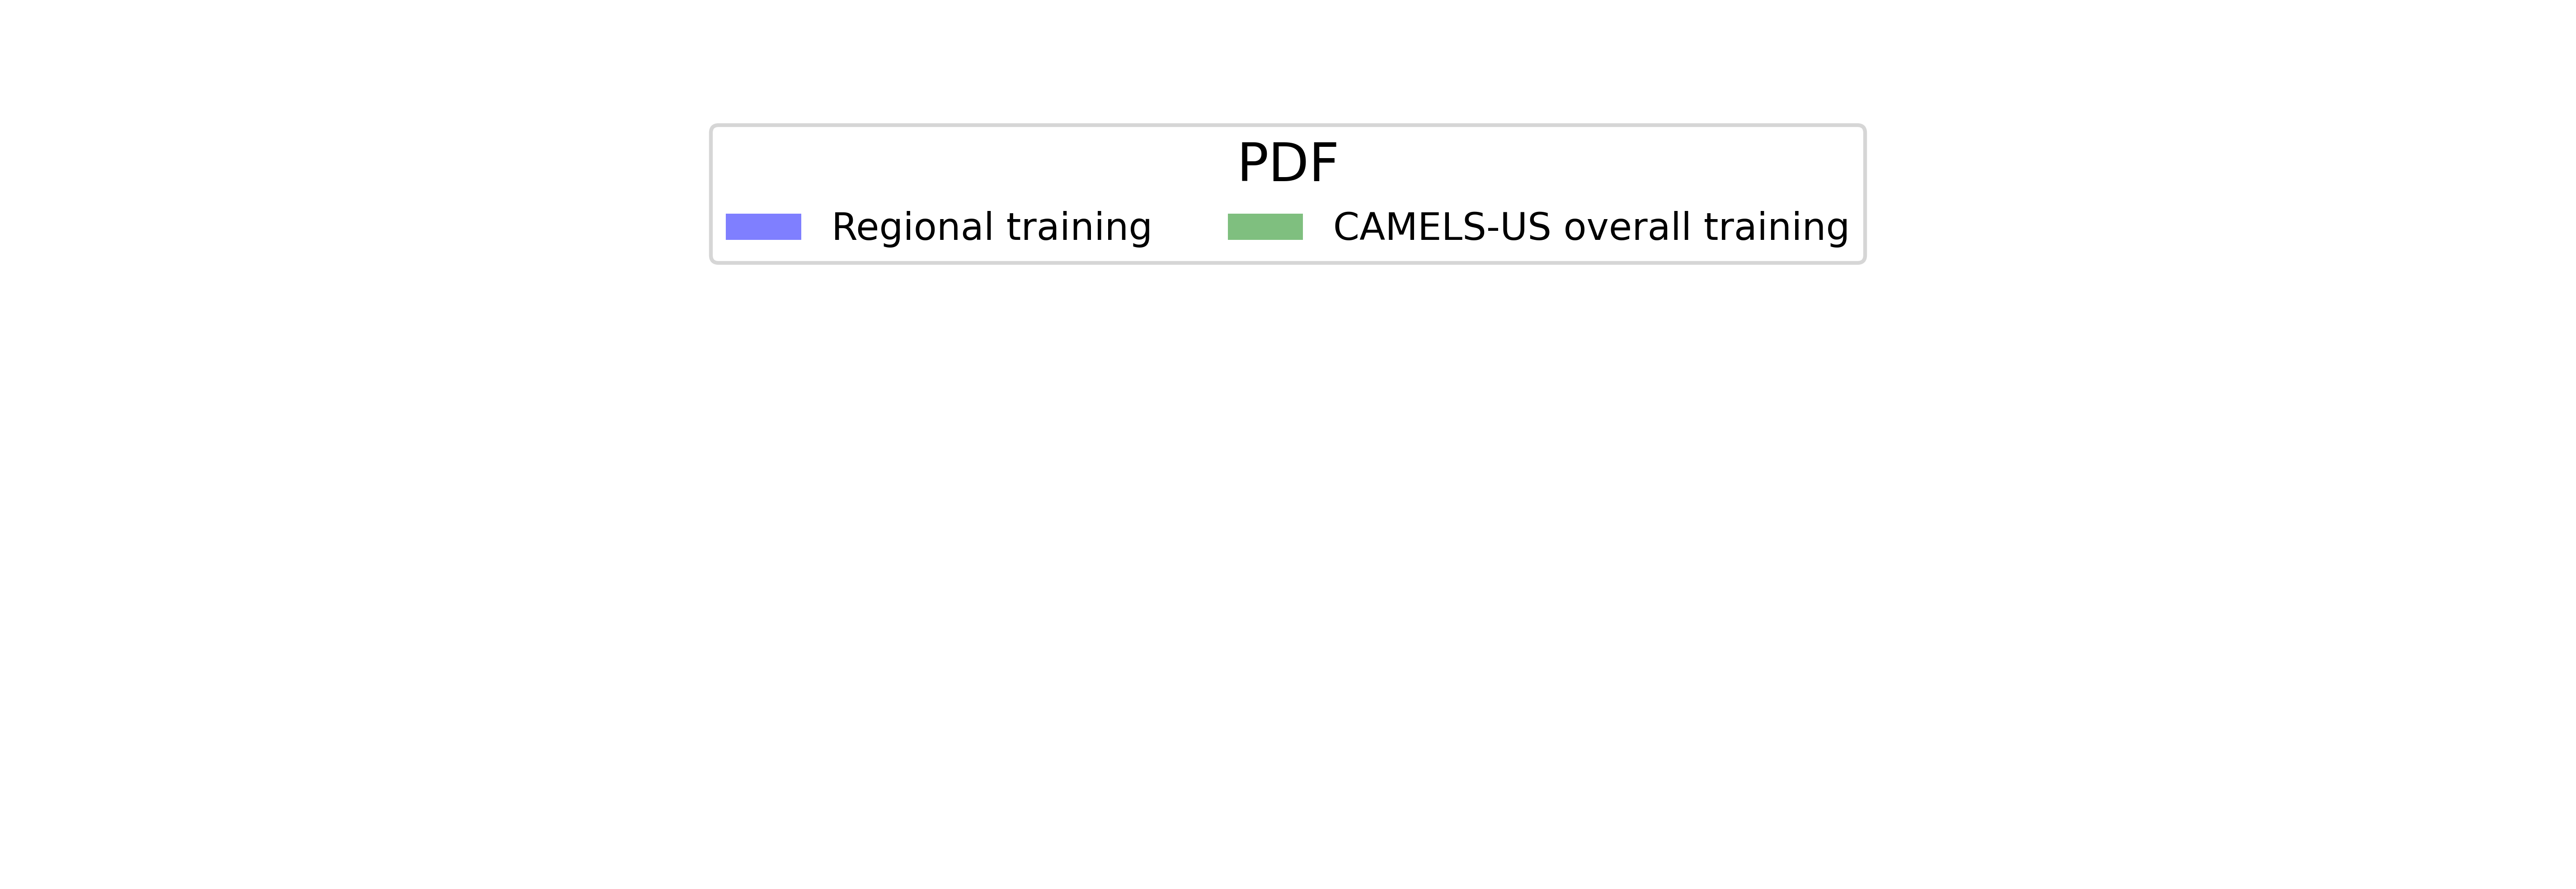

In [41]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.pyplot as plt

# Define font sizes
fontsize_tick = 10
fontsize_label = 14

# Create custom legend handles for CDF
legend_handles_cdf = [
    Line2D([0], [0], color='lightblue', lw=2, label='Regionally trained (single HUC)'),
    Line2D([0], [0], color='darkblue', lw=2, label='Regional median'),
    Line2D([0], [0], color='green', lw=2, label='CAMELS-US trained'),
    Line2D([0], [0], color='black', lw=2, linestyle='--', label='CDF = 0.5')
]

# Create custom legend handles for PDF
legend_handles_pdf = [
    Patch(facecolor='blue', alpha=0.5, label='Regional training'),
    Patch(facecolor='green', alpha=0.5, label='CAMELS-US overall training')
]

# Create a dummy figure to display the legends
fig, ax = plt.subplots(figsize=(12, 4), dpi = 600)
ax.axis('off')  # Hide the axis

# Add the legends to the figure for demonstration, setting title and label fonts
# legend1 = ax.legend(handles=legend_handles_cdf, loc='center', title='CDF', 
#                     frameon=True, ncol=4, bbox_to_anchor=(0.5, 0.8), 
#                     title_fontsize=fontsize_label, prop={'size': fontsize_tick})
legend2 = ax.legend(handles=legend_handles_pdf, loc='center', title='PDF', 
                    frameon=True, ncol=2, bbox_to_anchor=(0.5, 0.8), 
                    title_fontsize=fontsize_label, prop={'size': fontsize_tick})

# ax.add_artist(legend1)  # Add first legend back

# Even though axis is off, setting tick parameters as required
ax.tick_params(axis='both', which='major', labelsize=fontsize_tick)

# plt.tight_layout()
plt.show()